<a href="https://colab.research.google.com/github/mlelarge/graph_neural_net/blob/main/plot_accuracy_regular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# If running on Colab, uncomment the code below:
#!git clone https://github.com/mlelarge/graph_neural_net.git
#!pip3 install dgl
#cd graph_neural_net

In [16]:
import os
from pathlib import Path
import math
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from models import get_model
from toolbox.losses import triplet_loss
from toolbox import metrics
from loaders.data_generator import QAP_Generator
from loaders.siamese_loaders import siamese_loader
from toolbox.metrics import all_losses_acc, accuracy_linear_assignment
from toolbox.utils import check_dir

In [17]:
def get_device_config(model_path):
    config_file = os.path.join(model_path,'config.json')
    with open(config_file) as json_file:
        config_model = json.load(json_file)
    use_cuda = not config_model['cpu'] and torch.cuda.is_available()
    device = 'cuda' if use_cuda else 'cpu'
    return config_model, device

def load_model(model_path, config, device):
    model = get_model(config['arch'])
    model.to(device)
    model_file = os.path.join(model_path,'model_best.pth.tar')
    if device == 'cpu':
        checkpoint = torch.load(model_file,map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(model_file)
    model.load_state_dict(checkpoint['state_dict'])
    return model

def creat_args(config, num_ex = 1000):
    args = config['data']
    args['num_examples_test'] = num_ex
    n_vertices = args['n_vertices']
    edge_density = args['edge_density']
    deg = (n_vertices)*edge_density
    print(f'graphs with {n_vertices} vertices and average degree {deg}')
    return args, deg

def acc_2_error(mean_acc, q_acc):
    error = q_acc-mean_acc[:,np.newaxis]
    error[:,0] = -error[:,0]
    return error

def compute_all(list_noise,args,path_dataset,model,bs=50):
    num_batches = math.ceil(args['num_examples_test']/bs)
    all_losses = np.zeros((len(list_noise),num_batches))
    all_acc = np.zeros((len(list_noise),args['num_examples_test']))
    for i,noise in enumerate(list_noise):
        args['noise'] = noise
        gene_test = QAP_Generator('test', args, path_dataset)
        gene_test.load_dataset()
        test_loader = siamese_loader(gene_test, bs, gene_test.constant_n_vertices)
        all_losses[i,:], all_acc[i,:] = all_losses_acc(test_loader,model,criterion,device,eval_score=accuracy_linear_assignment)
    return all_losses, all_acc

def compute_quant(all_acc,quant_low=0.1,quant_up=0.9):
    mean_acc = np.mean(all_acc,1)
    num = len(mean_acc)
    q_acc = np.zeros((num,2))
    for i in range(num):
        q_acc[i,:] = np.quantile(all_acc[i,:],[quant_up, quant_low])
    return mean_acc, q_acc

# Downloading the pretrained model

The cell below should only be run once, it creates a folder `downloads/` and then downloads in this folder the pretrained model and the configuration file.

In [18]:
import requests
config_url = 'https://github.com/mlelarge/graph_neural_net/releases/download/QAP/config.json'
model_url = 'https://github.com/mlelarge/graph_neural_net/releases/download/QAP/model_best.pth.tar'
cwd = os.getcwd()
downloads = os.path.join(cwd, 'downloads')
check_dir(downloads)

r = requests.get(config_url)
with open(cwd+'/downloads/config.json', 'wb') as f:
    f.write(r.content)

r = requests.get(model_url)
with open(cwd+'/downloads/model_best.pth.tar', 'wb') as f:
    f.write(r.content)

In [19]:
model_path = cwd+'/downloads/'
config_model, device = get_device_config(model_path)
model = load_model(model_path,config_model,device)
criterion = triplet_loss()

Fetching model Siamese_Model - Simple_Node_Embedding 


In [20]:
args,deg  = creat_args(config_model)

graphs with 50 vertices and average degree 10.0


In [21]:
num = 23
list_noise = np.linspace(0, 0.22, num=num)

# Inference

The cell below will create dataset of graphs with various level of noise if they do not exist, otherwise it will only read them.

In [22]:
ROOT_DIR = Path.home()
path_dataset = os.path.join(ROOT_DIR, 'data/')
all_l, all_a = compute_all(list_noise,args,path_dataset,model);

Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.0_0.2/test.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.01_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.02_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.03_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.04_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.05_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.06_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.07_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.08_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.09_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.1_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.11_0.2/test.pkl
Reading dataset at /root/data/QAP_Regular_ErdosRenyi_1000_50_1.0_0.12_0.2/test.pkl
Readi

# Results

The FGNN has been trained with regular graphs with $50$ vertices, average degree $10$ and noise level $0.15$. The accuracy below is the fraction of matched vertices between two noisy versions of a given graph at various level of noise.

In [23]:
quant_low=0.1
quant_up=0.9
mc_50, q50 = compute_quant(all_a,quant_low=quant_low,quant_up=quant_up)

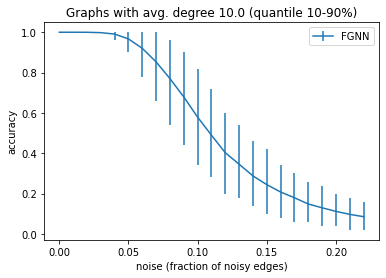

In [24]:
error_50 = acc_2_error(mc_50,q50)

plt.errorbar(list_noise,mc_50,yerr=error_50.T,label='FGNN');
plt.xlabel('noise (fraction of noisy edges)')
plt.ylabel('accuracy')
plt.title(f'Graphs with avg. degree {deg} (quantile {int(100*quant_low)}-{int(100*quant_up)}%)')
plt.legend()
plt.show()